In [17]:
import pandas as pd
import numpy as np 
import torch 
import networkx as nx 
import omnipath as op 
from matplotlib import pyplot as plt 
import copy 
from pypath.utils import mapping

from gsnn.simulate.nx2pyg import nx2pyg

from gsnn.models.GSNN import GSNN
from pypath.utils import mapping
from sklearn.metrics import r2_score

from scipy.stats import spearmanr
import seaborn as sbn 

from gsnn_mds.data.AMLDataset import AMLDataset
from gsnn_mds.eval.stratified_drug_eval import stratified_drug_evaluation

# auto import 
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
aml_expr = pd.read_csv('../proc/aml_expr.csv')
data = torch.load('../proc/graph.pt', weights_only=False)
drug = pd.read_csv('../proc/resp.csv')

aml_expr = aml_expr.fillna(0)

id2x = {} 
expr_ixs = np.array([i for i,n in enumerate(data.node_names_dict['input']) if "EXPR__" in n])
expr_names = np.array(data.node_names_dict['input'])[expr_ixs]
for i,row in aml_expr.iterrows(): 
    x = torch.zeros(len(data.node_names_dict['input']), dtype=torch.float32)
    x[expr_ixs] = torch.tensor(row[expr_names].values.astype(np.float32), dtype=torch.float32)
    id2x[row.id] = x

drug_inputs = [x.split('__')[1] for x in data.node_names_dict['input'] if x.split('__')[0] == 'DRUG']

batch_size = 256

train_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'train'], data.node_names_dict['input'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

test_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'test'], data.node_names_dict['input'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=10) 

val_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'val'], data.node_names_dict['input'])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')
print(f'Number of train samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
print(f'Number of val samples: {len(val_dataset)}')

In [19]:
drug_inputs = [x.split('__')[1] for x in data.node_names_dict['input'] if x.split('__')[0] == 'DRUG']

In [20]:
batch_size = 256

train_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'train'], data.node_names_dict['input'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

test_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'test'], data.node_names_dict['input'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=10) 

val_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'val'], data.node_names_dict['input'])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')
print(f'Number of train samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
print(f'Number of val samples: {len(val_dataset)}')


Using device: cuda
Number of train samples: 30696
Number of test samples: 3503
Number of val samples: 5486


In [21]:
model = GSNN(edge_index_dict=data.edge_index_dict,
             node_names_dict=data.node_names_dict, 
             channels = 5, 
             layers = 8, 
             dropout = 0.05, 
             nonlin = torch.nn.ELU, 
             bias=True,
             node_attn=True,
             share_layers = False, 
             add_function_self_edges=True, 
             norm = 'batch', 
             init= 'xavier_normal', 
             residual=True,
             checkpoint=True).to(device)

print('# parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad) )

optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
crit = torch.nn.MSELoss() 


# parameters: 11833168


In [22]:
torch.cuda.empty_cache()

In [23]:
best_loss = float('inf')
best_state = None 

for epoch in range(100):
    model.train()
    train_loss = 0.
    train_r2 = 0.
    for i, (x,y) in enumerate(train_loader):
        optim.zero_grad()
        yhat = model(x.to(device))
        loss = crit(yhat.squeeze(), y.squeeze().to(device))
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2) 
        
        optim.step()
        train_loss += loss.item()
        r2 = r2_score(y.detach().numpy(), yhat.detach().cpu().numpy()) 
        train_r2 += r2
        print(f'[{i}/{len(train_loader)} Loss: {loss.item():.4f} || R2: {r2:.4f}]', end='\r')

    train_loss /= len(train_loader)
    train_r2 /= len(train_loader) 

    model.eval() 
    with torch.no_grad():
        ys = []
        yhats = []
        for x,y in val_loader:
            yhat = model(x.to(device))
            ys.append(y.squeeze().numpy())
            yhats.append(yhat.squeeze().detach().cpu().numpy())
        
        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        r2 = r2_score(ys, yhats)
        mse = np.mean((ys - yhats) ** 2) 
        sr = spearmanr(ys, yhats).correlation

    if mse < best_loss:
        best_loss = mse
        best_state = {k:v.clone().detach().cpu() for k,v in model.state_dict().items()}

    print(f'Epoch {epoch+1} || Train Loss: {train_loss:.4f} || Train R2: {train_r2:.4f} || Val MSE: {mse:.4f} || Val R2: {r2:.4f} || Val Spearman R: {sr:.4f}')

Epoch 1 || Train Loss: 0.5094 || Train R2: 0.3764 || Val MSE: 0.4380 || Val R2: 0.4761 || Val Spearman R: 0.7063
Epoch 2 || Train Loss: 0.4006 || Train R2: 0.5075 || Val MSE: 0.3922 || Val R2: 0.5309 || Val Spearman R: 0.7263
Epoch 3 || Train Loss: 0.3600 || Train R2: 0.5578 || Val MSE: 0.3920 || Val R2: 0.5310 || Val Spearman R: 0.7369
Epoch 4 || Train Loss: 0.3348 || Train R2: 0.5886 || Val MSE: 0.3722 || Val R2: 0.5548 || Val Spearman R: 0.7483


KeyboardInterrupt: 

In [24]:
torch.cuda.empty_cache()

In [25]:
model.load_state_dict(best_state) 
model = model.to(device)

xs = [] 
ys = [] 
yhats = [] 

model.eval()
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        yhat = model(x.to(device))
        xs.append(x.squeeze().detach().cpu().numpy())
        ys.append(y.squeeze().detach().numpy())
        yhats.append(yhat.squeeze().detach().cpu().numpy())  

xs = np.concatenate(xs, axis=0)
ys = np.concatenate(ys, axis=0)
yhats = np.concatenate(yhats, axis=0)


In [26]:
r2 = r2_score(ys, yhats)
r = np.corrcoef(ys, yhats)[0, 1] 
mse = np.mean((ys - yhats) ** 2)
sr = spearmanr(ys, yhats).correlation

print(f'R2: {r2:.4f}')
print(f'Pearson R: {r:.4f}')
print(f'MSE: {mse:.4f}')
print(f'Spearman R: {sr:.4f}')

R2: 0.4128
Pearson R: 0.6809
MSE: 0.4591
Spearman R: 0.6544


In [ ]:
torch.save(model, '../proc/gsnn_aml.pt')

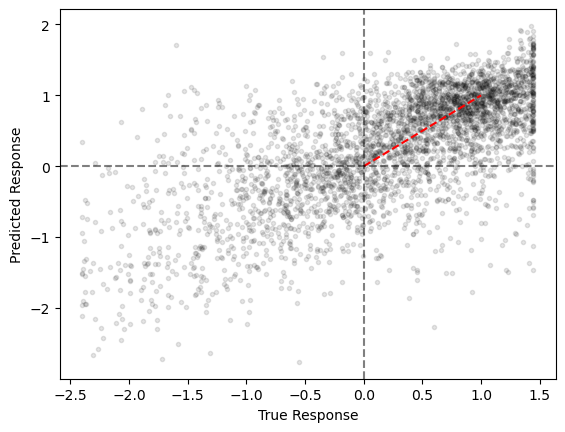

In [27]:
plt.figure() 
plt.plot(ys, yhats, 'k.', alpha=0.1)
plt.plot([0,1], [0,1], 'r--', alpha=1.)
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('True Response')
plt.ylabel('Predicted Response')
plt.show() 

In [28]:
# Test the simplified combination evaluation function
res = stratified_drug_evaluation(xs, ys, yhats, data.node_names_dict)
res.head() 

,n_samples,r2,pearson_r,mse,spearman_r
drug_combination,,,,,
17-aag (tanespimycin),33,0.414404,0.648609,0.189108,0.607955
a-674563,33,-0.076464,0.168113,0.371210,0.169786
abt-737,18,-0.252453,-0.115231,0.388677,-0.213622
at7519,33,0.223682,0.480273,0.267405,0.396056
azd1480,33,-0.124442,0.170352,0.316489,0.166458


In [29]:
res.sort_values(by='r2', ascending=False)

,n_samples,r2,pearson_r,mse,spearman_r
drug_combination,,,,,
birinapant + gw-2580,2,0.605864,1.000000,0.411914,1.000000
dasatinib + rapamycin,2,0.560742,1.000000,0.186787,1.000000
jq1,27,0.534366,0.758838,0.116609,0.783883
otx-015,23,0.530317,0.788346,0.251194,0.808300
17-aag (tanespimycin),33,0.414404,0.648609,0.189108,0.607955
...,...,...,...,...,...
blz945,1,NaN,NaN,0.027439,NaN
bms-754807,1,NaN,NaN,0.928885,NaN
baiclein,1,NaN,NaN,1.087886,NaN


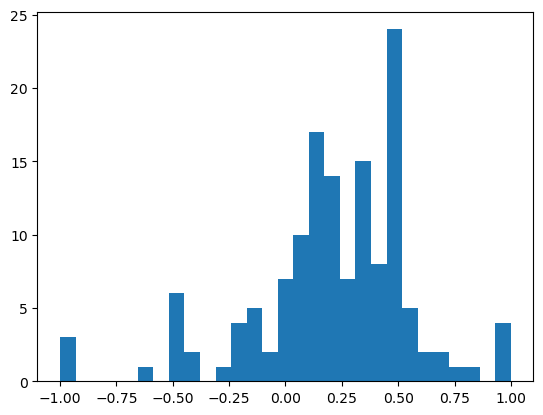

In [30]:
plt.figure() 
plt.hist(res.spearman_r, bins=np.linspace(-1, 1, 30))
plt.show()

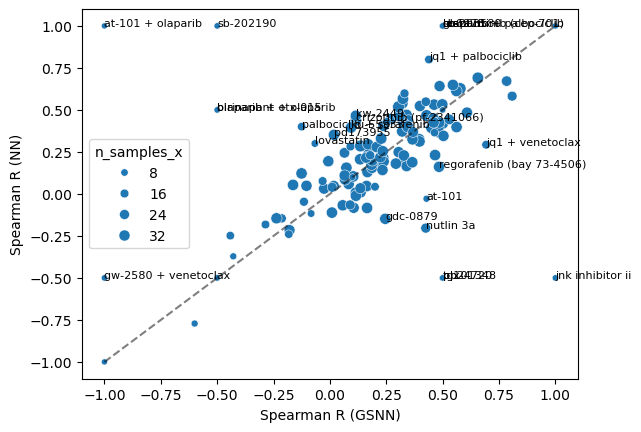

In [31]:
nn_res = pd.read_csv('drug_test_res_nn.csv', index_col=0) 

res2 = res.merge(nn_res, left_index=True, right_index=True, how='inner')

# drop row "overall"
res2 = res2.drop(index='overall')

plt.figure() 
sbn.scatterplot(x='spearman_r_x', y='spearman_r_y', size='n_samples_x', data=res2)
plt.plot([-1, 1], [-1, 1], 'k--', alpha=0.5)
plt.xlabel('Spearman R (GSNN)')
plt.ylabel('Spearman R (NN)')

# label outliers with drug name 
outliers = res2[(res2.spearman_r_x - res2.spearman_r_y).abs() > 0.3]

for i, row in outliers.iterrows():
    plt.text(row['spearman_r_x'], row['spearman_r_y'], i, fontsize=8)


plt.show() 